In [57]:
# compare_instrumental.ipynb
# 用于生成 Figure 2: (a) 效率对比 vs (b) 超参数影响

# In[1]:
# =============================================================================
# --- 1. 导入和设置 (Imports and Setup) ---
# =============================================================================
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import multiprocessing
from functools import partial
import time
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# 从我们创建的模块中导入函数
from cspsa_fig4 import run_cspsa_uncer_simulation
from cspsa_fig4 import run_cspsa_mis_simulation

In [58]:

# =============================================================================
# --- 2. 状态生成函数 (State Generation Functions) ---
# =============================================================================
def generate_werner_state(theta_deg, p):
    ket0, ket1 = qt.basis(2, 0), qt.basis(2, 1)
    theta_rad = np.deg2rad(theta_deg)
    psi_pure = np.cos(theta_rad) * qt.tensor(ket0, ket0) + np.sin(theta_rad) * qt.tensor(ket1, ket1)
    rho_pure = qt.ket2dm(psi_pure)
    return p * rho_pure + (1 - p) * qt.tensor(qt.qeye(2), qt.qeye(2)) / 4.0

def generate_random_mixed_state():
    dm = qt.rand_dm(4, distribution='hs')
    dm.dims = [[2, 2], [2, 2]]
    return dm

In [59]:

# =============================================================================
# --- 3. ✅ 任务1a 配置: 效率对比 ---
# =============================================================================
# 固定超参数，对比不同量子态
ALGORITHMS_1a = {'CSPSA': run_cspsa_uncer_simulation}
Standeviation_1a = {'0.2': 0.2, '0.1':0.1}
HPARAMS_1a = {
    'fixed': {
        'cspsa': (1.0, 1.25, 0.25, 1/6.0)
    }
}
STATES_1a = {
    r"Max Entangled": generate_werner_state(45.0, 1.0),
    "Random Mixed 1": generate_random_mixed_state(),
    "Random Mixed 2": generate_random_mixed_state(),
    "Random Mixed 3": generate_random_mixed_state(),
    "Random Mixed 4": generate_random_mixed_state(),
}
CONFIG_1a = {'iterations':400, 'num_repetitions': 30}

In [60]:

# =============================================================================
# --- 4. ✅ 任务1b 配置: 超参数影响 ---
# =============================================================================
# 固定量子态，对比不同超参数
ALGORITHMS_1b = {'CSPSA': run_cspsa_mis_simulation}
HPARAMS_1b = {
    'fixed': {
        'cspsa': (1.0, 1.25, 0.25, 1/6.0)
    }
}
STATES_1b = {
    r"Max Entangled": generate_werner_state(45.0, 1.0),
    "Random Mixed 1": generate_random_mixed_state(),
    "Random Mixed 2": generate_random_mixed_state(),
    "Random Mixed 3": generate_random_mixed_state(),
    "Random Mixed 4": generate_random_mixed_state(),
}
CONFIG_1b = {'iterations':400, 'num_repetitions': 30}

In [62]:

# =============================================================================
# --- 5. 实验执行循环 (Run Simulations) ---
# =============================================================================
def run_simulations(task_name, algorithms, hparams, states, config):
    all_results = []
    print(f"\n>>>>>> STARTING TASK: {task_name} <<<<<<")
    start_time = time.time()
    for hparam_name, hparam_values in hparams.items():
        for state_name, state_rho in states.items():
            for algo_name in algorithms:
                for standeviation_name, standeviation_values in Standeviation_1a:
                    print(f"...Running: [Algo: {algo_name}] | [State: {state_name}] | [Hparam: {hparam_name}]...")
                    current_config = {'state': state_rho, 'hparams': hparam_values,'standeviation': standeviation_values, **config}
                    worker_function = partial(algorithms[algo_name], current_config)
                    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
                      histories = pool.map(worker_function, range(config['num_repetitions']))
                    mean_history = np.mean(np.abs(histories), axis=0)
                    all_results.append({
                      'hparam_set': hparam_name,
                      'state_name': state_name,
                      'algo_name': algo_name,
                      'mean_history': mean_history,
                      'standeviation': standeviation_name
                    })
    end_time = time.time()
    print(f">>>>>> TASK {task_name} COMPLETE IN {end_time - start_time:.2f} s <<<<<<\n")
    return all_results

if __name__ == '__main__':
    results_1a = run_simulations("1a: Efficiency", ALGORITHMS_1a, HPARAMS_1a, STATES_1a, CONFIG_1a)
    results_1b = run_simulations("1b: Hyperparameters", ALGORITHMS_1b, HPARAMS_1b, STATES_1b, CONFIG_1b)



>>>>>> STARTING TASK: 1a: Efficiency <<<<<<


ValueError: too many values to unpack (expected 2)

Generating Figure 2...


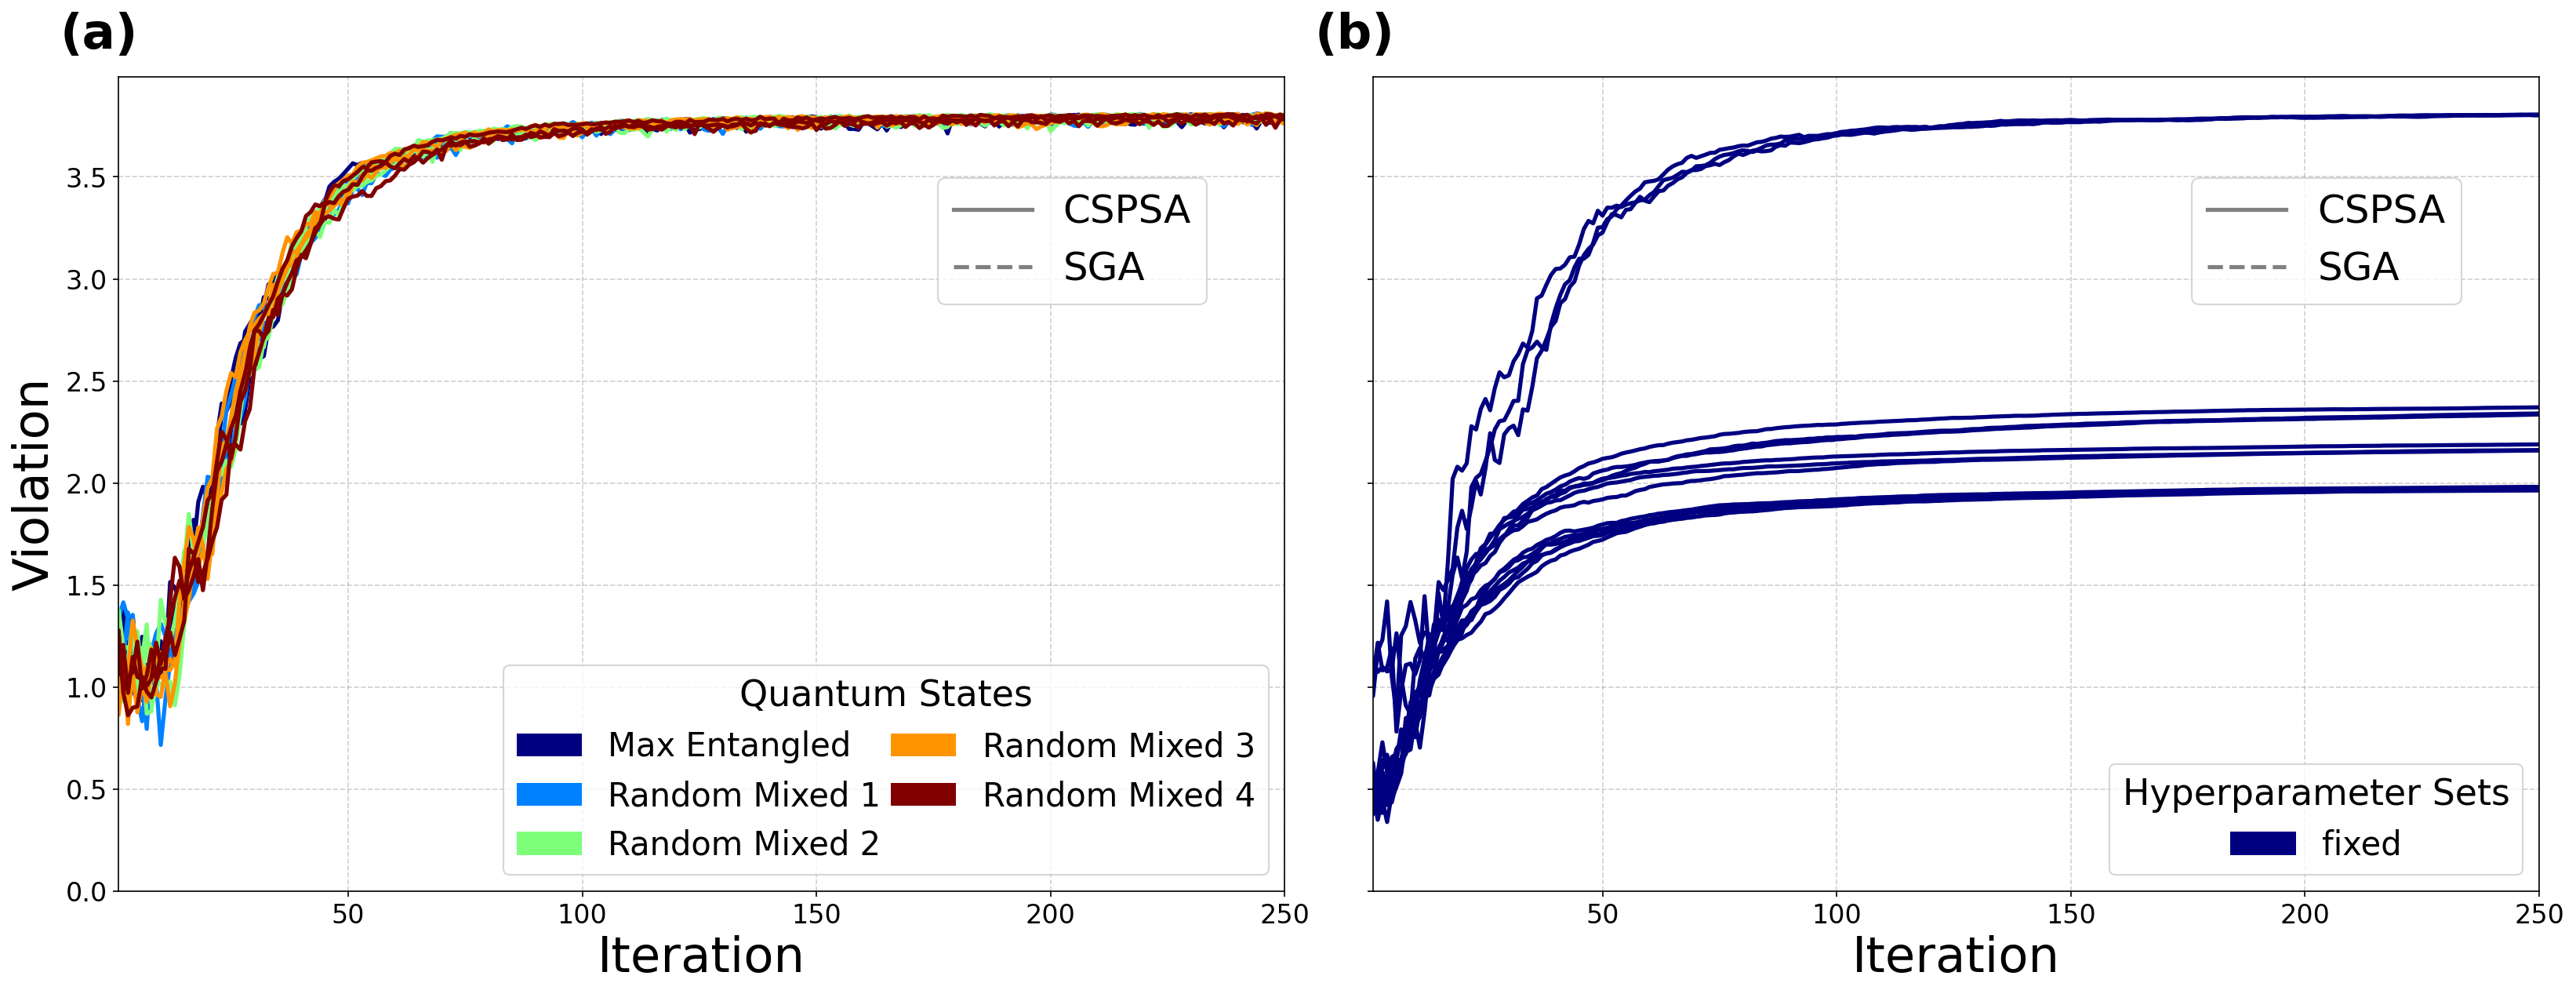

In [21]:
    # =============================================================================
    # --- 6. 绘图 (Plotting Figure 2) ---
    # =============================================================================
    print("Generating Figure 2...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9), sharey=True, dpi=150)
    plt.style.use('default') # 保持您满意的风格

    # --- 图(a): 效率对比 ---
    colors_1a = plt.cm.jet(np.linspace(0, 1, len(STATES_1a)))
    state_colors = {name: colors_1a[i] for i, name in enumerate(STATES_1a.keys())}
    algo_lines = {'CSPSA': '-', 'SGA': '--'}

    for r in results_1a:
        ax1.plot(r['mean_history'], color=state_colors[r['state_name']], linestyle=algo_lines[r['standeviation_name']], linewidth=2.5)

    ax1.text(-0.05, 1.08, '(a)', transform=ax1.transAxes, fontsize=30, fontweight='bold', va='top')

    # 图例 (a)
    leg_states = [Patch(facecolor=state_colors[name], label=name) for name in STATES_1a.keys()]
    leg_algos = [Line2D([0], [0], color='gray', lw=2.5, linestyle=ls, label=name) for name, ls in algo_lines.items()]
    legend1 = ax1.legend(handles=leg_states, loc='lower right', title='Quantum States', ncol=2, columnspacing=0.3, fontsize=20, title_fontsize=22)
    ax1.add_artist(legend1)
    ax1.legend(handles=leg_algos, loc='upper right', bbox_to_anchor=(0.95, 0.900), fontsize=24)
    # --- 新增代码: 设置a图的x轴范围 ---
    ax1.set_xlim(1, 250)
    # --- 图(b): 超参数影响 ---
    colors_1b = plt.cm.jet(np.linspace(0, 1, len(HPARAMS_1b)))
    hparam_colors = {name: colors_1b[i] for i, name in enumerate(HPARAMS_1b.keys())}

    for r in results_1b:
        ax2.plot(r['mean_history'], color=hparam_colors[r['hparam_set']], linestyle=algo_lines[r['algo_name']], linewidth=2.5)

    ax2.text(-0.05, 1.08, '(b)', transform=ax2.transAxes, fontsize=30, fontweight='bold', va='top')

    # 图例 (b)
    leg_hparams = [Patch(facecolor=hparam_colors[name], label=name) for name in HPARAMS_1b.keys()]
    legend2 = ax2.legend(handles=leg_hparams, loc='lower right', ncol=5 , columnspacing=0.3 ,title='Hyperparameter Sets', fontsize=20, title_fontsize=22)
    ax2.add_artist(legend2)
    ax2.legend(handles=leg_algos, loc='upper right', bbox_to_anchor=(0.95, 0.90), fontsize=24)
    # --- 新增代码: 设置a图的x轴范围 ---
    ax2.set_xlim(1, 250)
    # --- 全局设置 ---
    for ax in [ax1, ax2]:
        ax.set_xlabel("Iteration", fontsize=30)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_ylim(bottom=0)
        ax.tick_params(axis='both', which='major', labelsize=16)

    ax1.set_ylabel("Violation", fontsize=30)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    plt.savefig("figure2_instrumental_analysis.pdf", format='pdf', bbox_inches='tight')
    plt.show()

